In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar #planck's constant in J s
hbar = hbar * 6.242 * (10**(18)) #planck's constant in eV s
print(hbar)


6.582637285747309e-16


In [12]:
Arg_file = "Aragonite-VIBRATIONS-1.mol"
Cal_file = "Calcite-VIBRATIONS-1.mol"
Vat_file = "Vaterite-VIBRATIONS-1.mol"

def Natoms(file): #To count no of atoms in file
    natoms = 0
    with open(file) as fp:
        for line in iter(fp.readline, ' [Atoms] AU\n'):
            pass
        for line in iter(fp.readline, ' [FREQ]\n'):
            natoms = natoms+1
    return natoms

def read_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]  # Skip the header
        data = np.loadtxt(lines)
    return data

def read_freq_to_array(file):
    #The final frequency array is in 2piHz (angular frequency)
    #The final energy array is in eV
    freq_arr = np.array([])
    with open(file) as fp:
        for line in iter(fp.readline, ' [FREQ]\n'):
            pass
        for line in iter(fp.readline, ' [FR-COORD]\n'):
            freq = float(line.rstrip().strip())
            freq_arr = np.append(freq_arr,[freq])
    natoms = Natoms(file)
    #Ene_arr2 = 0.5 * 0.000123984 * freq_arr # in eV
    freq_arr = 2 * np.pi * 2.99793 * (10**(10)) * freq_arr # in 2piHz (angular frequency)
    Ene_arr = 0.5*hbar*freq_arr   #1/2 * hbar * omega in eV    
    Nfreq = len(freq_arr)
    #print(Ene_arr2 - Ene_arr )
    print("\nThere are {} atoms and {} number of frequencies\n".format(natoms, Nfreq))
    print("\nFrequency of vibration in 2piHz (angular frequency) for from the file "+file+"\n")
    print(freq_arr)
    print("\nThe energy of vibration for the above frequency "+file+"\n")    
    print(Ene_arr)
    print(np.sum(Ene_arr))
    return natoms, freq_arr, Ene_arr

def FreeEntVib(T,Evib, natoms):
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        #USAGE: VibrationFreeEnergy, VibrationalEnergy, VibrationEntropyEnergy = FreeEntVib(T,Evib) 
        #INPUT TEMPERATURE T AND VIBRATIONAL ENERGY EVIB
        #OUTPUT FREE ENERGY OF VIBRATION AND VIB TERM, ENT TERM
        #FOR REF https://doi.org/10.1103/PhysRevB.65.035406
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        kb = 8.617333262e-05 #eV/K
        B = 1/(kb*T)
        x = B*Evib #Evib = 1/2 * hbar * omega
        #print(2*x)
        exp = np.exp(2*x) 
        termvib     = natoms * (Evib + (2*Evib/(exp - 1)))
        SVib  = natoms * kb* ( ( (2*x/(exp - 1)) - np.log(1-(1/exp)) ) )
        termentropy = T*SVib 
        F = termvib - termentropy
        #print(SVib)
        return F,termvib,termentropy, SVib
    
def ent_vib(T,fq):
    #T in Kelvin
    #fq in cm-1
    kb = 8.617333262e-05 #eV/K
    fqcm = fq
    fqomega = 2 * np.pi * 2.99793 * np.power(10, 10) * fq
    B = np.divide(1,kb*T)
    print(B)
    x = B*hbar*fqomega
    y = np.exp(x)
    term1 = x/(y-1)
    term2 = np.log((y-1)/y)
    S = kb * ( term1 - term2 )
    return S

    
def plot_Temp_vs_Ent(Temp,Entropy, Label):
    plt.plot(Temp,Entropy,label=Label)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Entropy per atom (eV/K)")
    plt.legend()
    #plt.savefig(Label+".png")
    plt.show()
    #plt.close()
    return


def Entropy1(Temp,vib_ene_tot,natom,Label, write_fname):
    FreeEneArg,EnevibArg,EneEntropyArg, SVibArg = FreeEntVib(Temp,vib_ene_tot,1) 
    SVibArgPatom = SVibArg/natom
    plot_Temp_vs_Ent(Temp,SVibArgPatom, Label)
    with open(write_fname, "w") as file:
        file.write("Temperature Entropy\n")
        for temp, svibarg in zip(Temp, SVibArgPatom):
            file.write(f"{temp} {svibarg}\n")
    return

def Entropy2(Temp,vib_ene,natoms,Label,write_fname):
    #Takes in array of 0.5*hbar*omega and finds array of entropy
    #then it sums over all omega to give a function of T
    SVibArg0,FreeEneArg0,EnevibArg0,EneEntropyArg0 = [],[],[],[]
    for i in Temp:
        FreeEneArg,EnevibArg,EneEntropyArg, SVibArg = FreeEntVib(i,vib_ene,1) 
        SVibArg0.append(np.sum(SVibArg))
        FreeEneArg0.append(np.sum(FreeEneArg))
        EnevibArg0.append(np.sum(EnevibArg))
        EneEntropyArg0.append(np.sum(EneEntropyArg))
    SVibArg0,FreeEneArg0 = np.array(SVibArg0),np.array(FreeEneArg0)
    EnevibArg0,EneEntropyArg0 = np.array(EnevibArg0),np.array(EneEntropyArg0)
    SVibArgPatom = SVibArg0/natoms
    FreeEneArgPatom = FreeEneArg0/natoms
    EnevibArgPatom = EnevibArg0/natoms
    EneEntropyArgPatom = EneEntropyArg0/natoms
    plot_Temp_vs_Ent(Temp,SVibArgPatom, Label)
    with open(write_fname, "w") as file:
        file.write("Temperature Entropy\n")
        for temp, svibarg, entene, vibene, fene in zip(Temp,SVibArgPatom,EneEntropyArgPatom,EnevibArgPatom,FreeEneArgPatom):
            file.write(f"{temp} {svibarg} {entene} {vibene} {fene}\n")
    return

In [13]:
NArg, Arg_freq, Arg_ene  = read_freq_to_array(Arg_file)
NCal, Cal_freq, Cal_ene  = read_freq_to_array(Cal_file)
NVat, Vat_freq, Vat_ene  = read_freq_to_array(Vat_file)


There are 20 atoms and 57 number of frequencies


Frequency of vibration in 2piHz (angular frequency) for from the file Aragonite-VIBRATIONS-1.mol

[2.75556364e+13 2.92822943e+13 3.05043502e+13 3.29745067e+13
 3.34992178e+13 3.51389107e+13 3.56417198e+13 4.62189405e+13
 4.65715993e+13 4.75144010e+13 4.78786666e+13 4.90754183e+13
 5.09148769e+13 5.21256410e+13 5.23278685e+13 5.83090931e+13
 5.95623601e+13 6.01105314e+13 6.20136724e+13 6.39400105e+13
 6.45580365e+13 6.50551269e+13 6.66004640e+13 6.85425240e+13
 6.94538351e+13 7.15163610e+13 7.20310986e+13 7.35171560e+13
 7.48368946e+13 7.53007312e+13 7.68166348e+13 7.69938457e+13
 7.72265682e+13 1.34885935e+14 1.36229575e+14 1.37057324e+14
 1.37077075e+14 1.39234622e+14 1.40074171e+14 1.40729212e+14
 1.41425768e+14 1.56615139e+14 1.56927002e+14 1.64982198e+14
 1.65214745e+14 2.05132704e+14 2.05234828e+14 2.05507842e+14
 2.05834288e+14 2.59612991e+14 2.63666366e+14 2.68912555e+14
 2.71708534e+14 2.74128037e+14 2.74207761e+14 2.74525378e+

In [14]:
Temp = np.array([i for i in range(1,1000)]) # in Kelvin
Arg_ene_tot = np.sum(Arg_ene)
Cal_ene_tot = np.sum(Cal_ene)
Vat_ene_tot = np.sum(Vat_ene)
print(Arg_ene_tot)
print(Cal_ene_tot)
print(Vat_ene_tot)

2.1745254738711415
3.13990341087118
6.302788413533886


In [15]:
Entropy1(Temp,Arg_ene_tot,NArg,"Arg","1TempEntrArg.dat")
Entropy1(Temp,Cal_ene_tot,NCal,"Cal","1TempEntrCal.dat")
Entropy1(Temp,Vat_ene_tot,NVat,"Vat","1TempEntrVat.dat")

C:\Users\syams\AppData\Local\Temp\ipykernel_6844\3337829198.py:55: RuntimeWarning: overflow encountered in exp
  exp = np.exp(2*x)


In [16]:
Entropy2(Temp,Arg_ene,NArg,"Arg","2TempEntrArg.dat")
Entropy2(Temp,Cal_ene,NCal,"Cal","2TempEntrCal.dat")
Entropy2(Temp,Vat_ene,NVat,"Vat","2TempEntrVat.dat")

C:\Users\syams\AppData\Local\Temp\ipykernel_6844\3337829198.py:55: RuntimeWarning: overflow encountered in exp
  exp = np.exp(2*x)


<IPython.core.display.Javascript object>


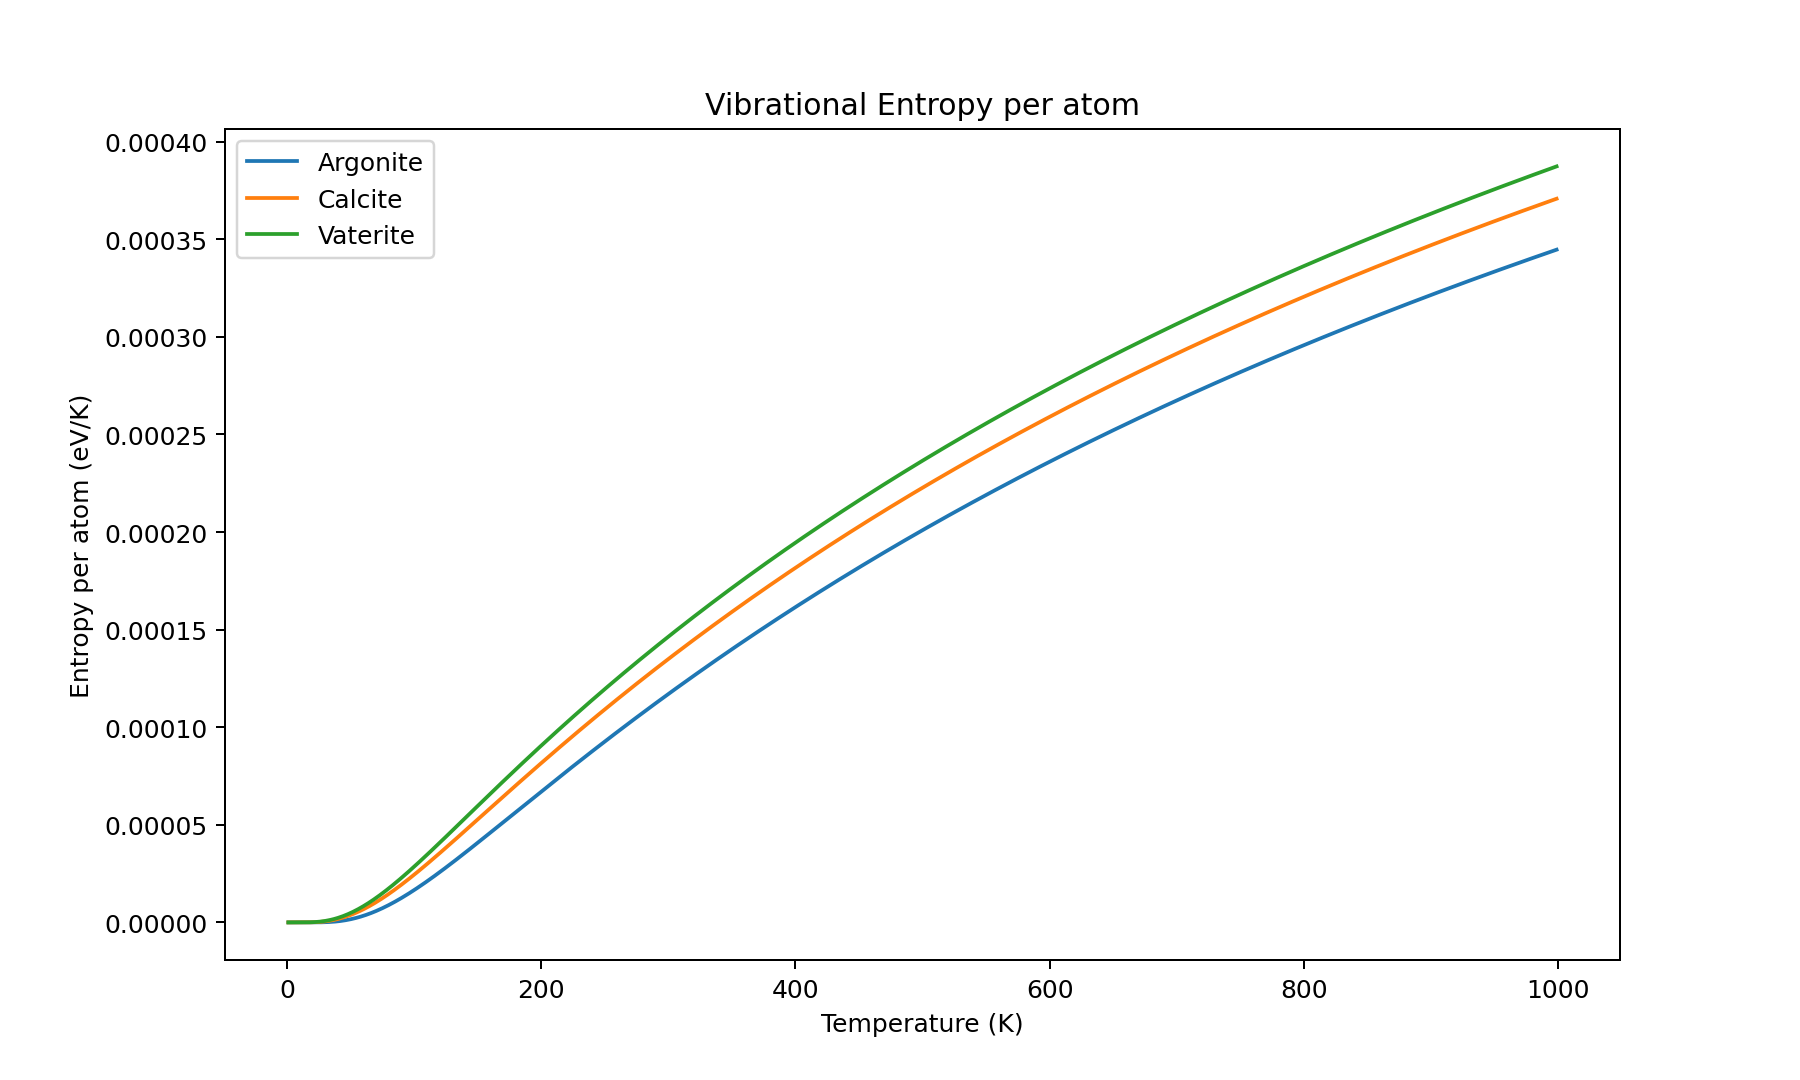

In [7]:
data_argonite = read_data('2TempEntrArg.dat')
data_calcite = read_data('2TempEntrCal.dat')
data_vaterite = read_data('2TempEntrVat.dat')

# Extract x (Temp) and y (entropy) data
x_argonite, y_argonite = data_argonite[:, 0], data_argonite[:, 1]
x_calcite, y_calcite   = data_calcite[:, 0], data_calcite[:, 1]
x_vaterite, y_vaterite = data_vaterite[:, 0], data_vaterite[:, 1]

# Extract entropy energy
y_argentene = data_argonite[:, 2]
y_calentene = data_calcite[:, 2]
y_vatentene = data_vaterite[:, 2]

# Extract vib energy
y_argvibene = data_argonite[:, 3]
y_calvibene = data_calcite[:, 3]
y_vatvibene = data_vaterite[:, 3]

#Extract free energy contribution
y_argfene = data_argonite[:, 4]
y_vatfene = data_calcite[:, 4]
y_calfene = data_vaterite[:, 4]

# Create a single plot for all the data
plt.figure(figsize=(10, 6))
plt.plot(x_argonite, y_argonite, label='Argonite')
plt.plot(x_calcite, y_calcite, label='Calcite')
plt.plot(x_vaterite, y_vaterite, label='Vaterite')

# Set labels for the axes
plt.title("Vibrational Entropy per atom")
plt.xlabel('Temperature (K)')
plt.ylabel('Entropy per atom (eV/K)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


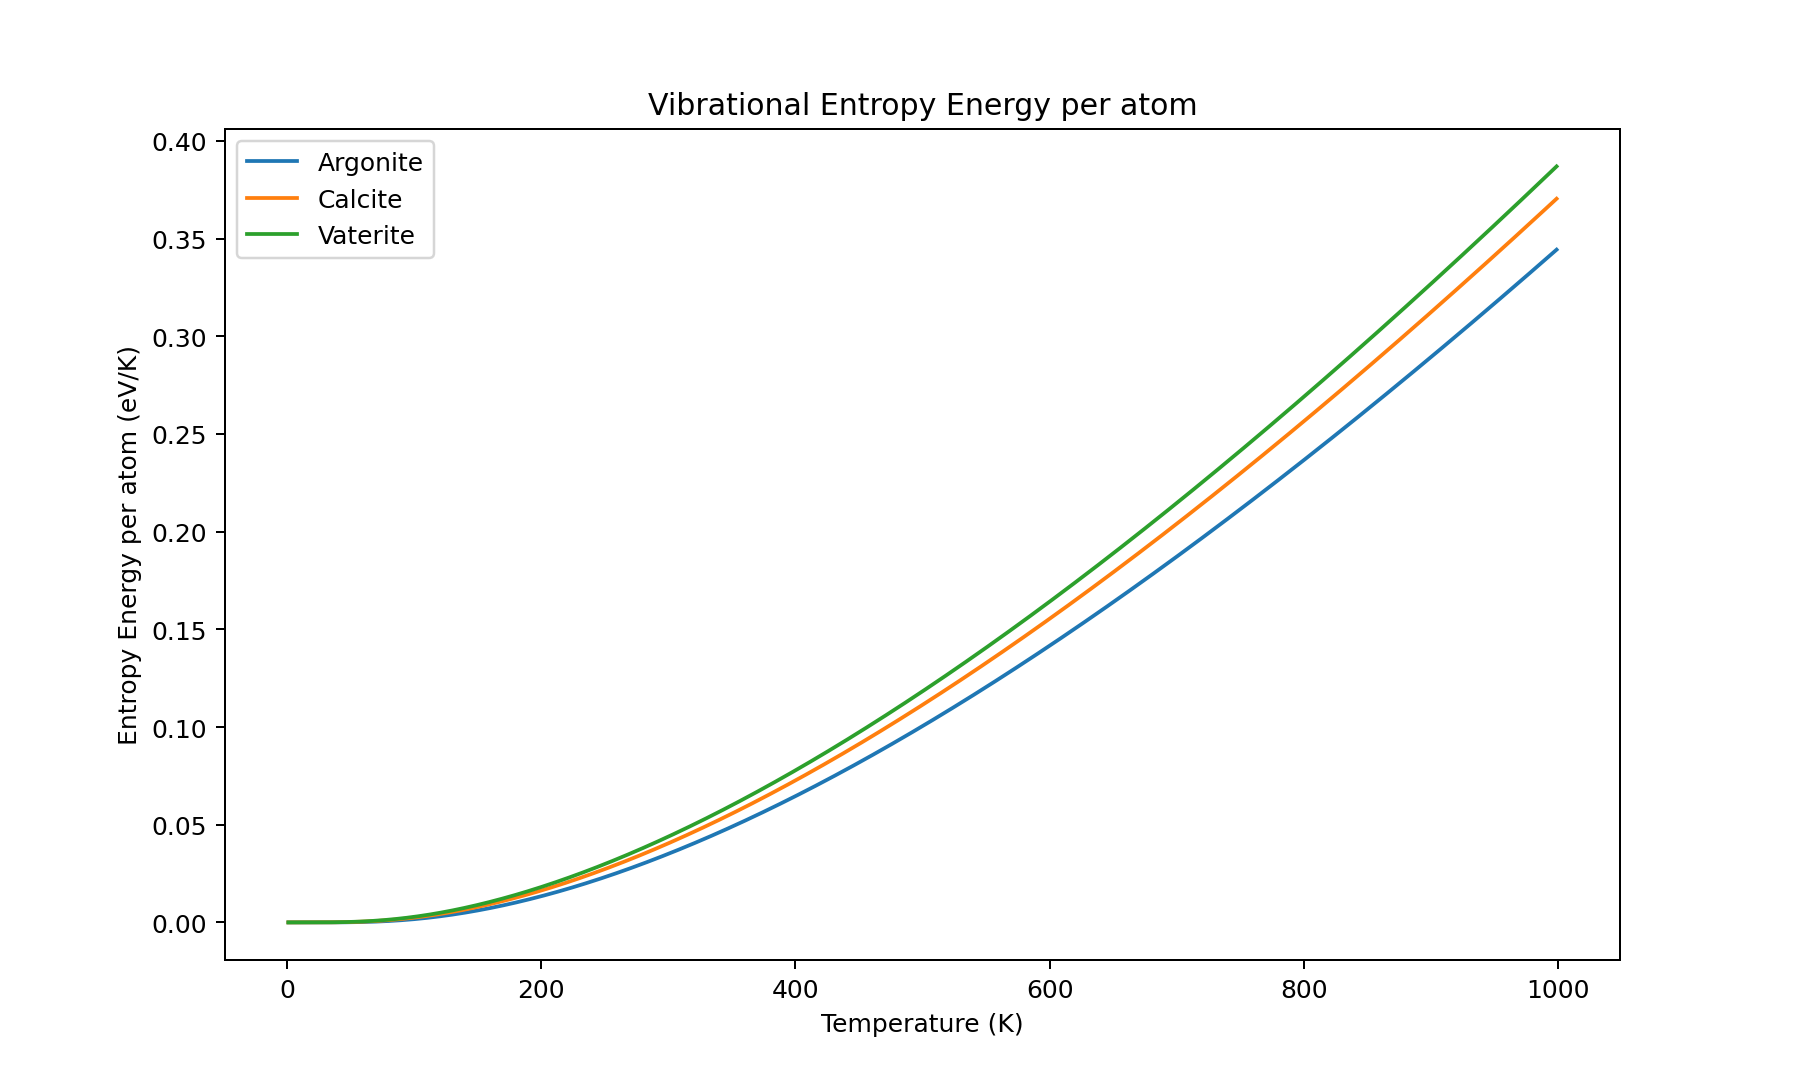

In [8]:
# Create a single plot for all the data
plt.figure(figsize=(10, 6))
plt.plot(x_argonite, y_argentene , label='Argonite')
plt.plot(x_calcite,  y_calentene , label='Calcite')
plt.plot(x_vaterite, y_vatentene , label='Vaterite')

# Set labels for the axes
plt.title("Vibrational Entropy Energy per atom")
plt.xlabel('Temperature (K)')
plt.ylabel('Entropy Energy per atom (eV/K)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


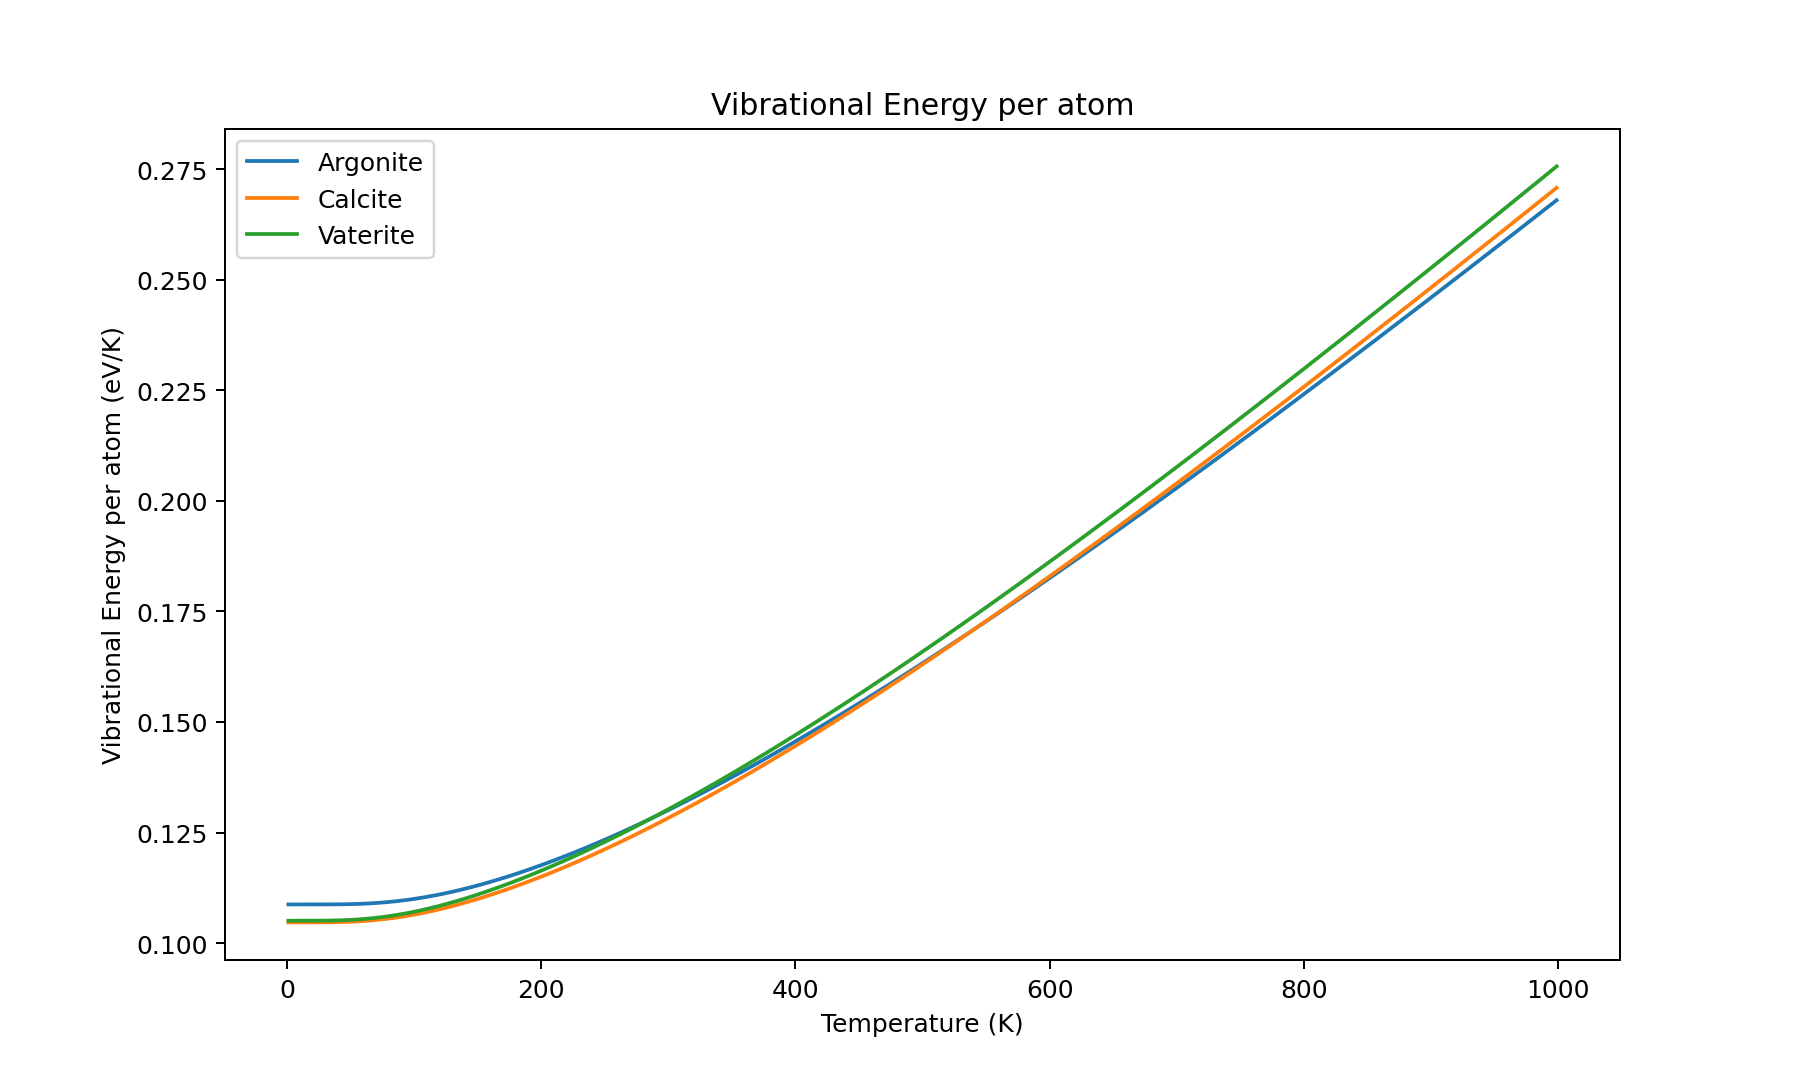

In [9]:
# Create a single plot for all the data
plt.figure(figsize=(10, 6))
plt.plot(x_argonite, y_argvibene , label='Argonite')
plt.plot(x_calcite,  y_calvibene , label='Calcite')
plt.plot(x_vaterite, y_vatvibene , label='Vaterite')

# Set labels for the axes
plt.title("Vibrational Energy per atom")
plt.xlabel('Temperature (K)')
plt.ylabel('Vibrational Energy per atom (eV/K)')

# Add a legend
plt.legend()

# Show the plot
plt.show()


<IPython.core.display.Javascript object>


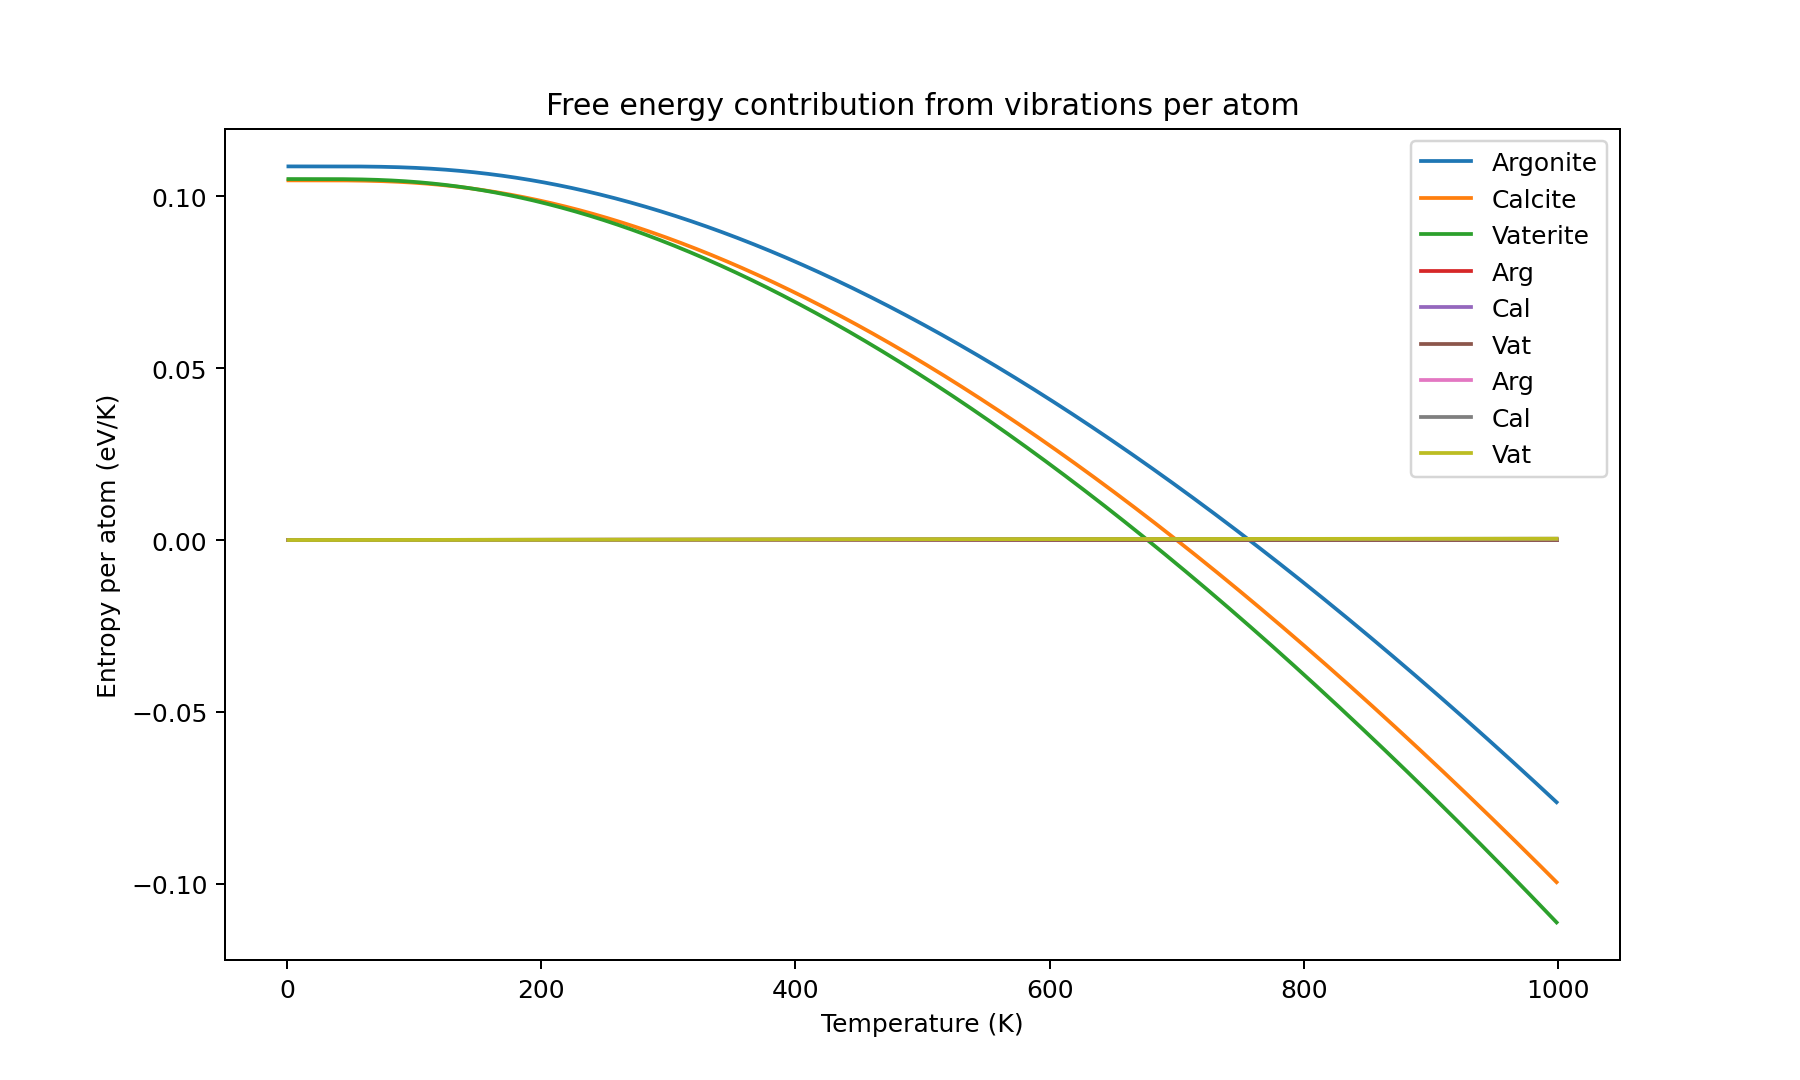

In [10]:
# Create a single plot for all the data
plt.figure(figsize=(10, 6))
plt.plot(x_argonite, y_argfene , label='Argonite')
plt.plot(x_calcite,  y_vatfene , label='Calcite')
plt.plot(x_vaterite, y_calfene , label='Vaterite')

# Set labels for the axes
plt.title("Free energy contribution from vibrations per atom")
plt.xlabel('Temperature (K)')
plt.ylabel('Free Energy per atom (eV/K)')


# Add a legend
plt.legend()

# Show the plot
plt.show()

In [11]:
#Writing to file
#Argfile = "TempEntrArg.dat"
#Calfile = "TempEntrCal.dat"
#Vatfile = "TempEntrVat.dat"
#
#with open(Argfile, "w") as file:
#    file.write("Temperature Entropy\n")
#    for temp, svibarg in zip(Temp, SVibArgPatom):
#        file.write(f"{temp} {svibarg}\n")
#        
#with open(Calfile, "w") as file:
#    file.write("Temperature Entropy\n")
#    for temp, svibarg in zip(Temp, SVibCalPatom):
#        file.write(f"{temp} {svibarg}\n")
#
#with open(Vatfile, "w") as file:
#    file.write("Temperature Entropy\n")
#    for temp, svibarg in zip(Temp, SVibVatPatom):
#        file.write(f"{temp} {svibarg}\n")
#FreeEneArg,EnevibArg,EneEntropyArg, SVibArg = FreeEntVib(Temp,Arg_ene_tot,1) #NArg)
#FreeEneCal,EnevibCal,EneEntropyCal, SVibCal = FreeEntVib(Temp,Cal_ene_tot,1) #NCal)
#FreeEneVat,EnevibVat,EneEntropyVat, SVibVat = FreeEntVib(Temp,Vat_ene_tot,1) #NVat)
#SVibArgPatom = SVibArg0/NArg
#SVibCalPatom = SVibCal0/NCal
#SVibVatPatom = SVibVat0/NVat